In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.pipeline import Pipeline


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [52]:
import pandas as pd
df = pd.read_csv("yellow_tripdata_2015-01.csv")

# Using a sample of the total data for faster processing
df = df.sample(n=100000)

# Dropping null-values, resetting index
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

# Removing extreme distances (likely bad data)
df = df.loc[~(df['trip_distance'] > 700), :]


In [53]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-18 14:06:45,2015-01-18 14:12:40,1,1.04,-73.985237,40.757912,1,N,-73.994942,40.744820,2,6.0,0.0,0.5,0.00,0.0,0.3,6.80
1,2,2015-01-23 00:14:05,2015-01-23 00:23:02,2,2.45,-74.008118,40.739422,1,N,-73.986290,40.760777,1,9.5,0.5,0.5,2.16,0.0,0.3,12.96
2,2,2015-01-05 12:28:39,2015-01-05 12:41:41,1,1.91,-73.992584,40.758907,1,N,-73.980186,40.741909,2,10.0,0.0,0.5,0.00,0.0,0.3,10.80
3,2,2015-01-19 11:01:14,2015-01-19 11:11:33,5,1.47,-73.997353,40.741489,1,N,-74.001579,40.724216,1,8.5,0.0,0.5,2.12,0.0,0.3,11.42
4,2,2015-01-30 21:59:30,2015-01-30 22:16:23,1,4.87,-74.010056,40.714497,1,N,-73.987648,40.773651,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               100000 non-null  int64  
 1   tpep_pickup_datetime   100000 non-null  object 
 2   tpep_dropoff_datetime  100000 non-null  object 
 3   passenger_count        100000 non-null  int64  
 4   trip_distance          100000 non-null  float64
 5   pickup_longitude       100000 non-null  float64
 6   pickup_latitude        100000 non-null  float64
 7   RateCodeID             100000 non-null  int64  
 8   store_and_fwd_flag     100000 non-null  object 
 9   dropoff_longitude      100000 non-null  float64
 10  dropoff_latitude       100000 non-null  float64
 11  payment_type           100000 non-null  int64  
 12  fare_amount            100000 non-null  float64
 13  extra                  100000 non-null  float64
 14  mta_tax                100000 non-nul

In [55]:
# Filtering out rows where either pickup or dropoff latitude/longitude is 0
df = df[(df['pickup_latitude'] != 0) & 
        (df['pickup_longitude'] != 0) & 
        (df['dropoff_latitude'] != 0) & 
        (df['dropoff_longitude'] != 0)]

# Doing the same for rows where trip distance is 0
df = df[df['trip_distance'] != 0]

money_dist_columns = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']

# Convert negative values to positive for the specified columns
for column in money_dist_columns:
    df[column] = df[column].abs()


In [56]:
X = df.select_dtypes("number").copy()
#X.drop(columns=["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"], inplace=True)

# Dropping dummy vars
to_drop = ["VendorID", "RateCodeID", "payment_type"]
X.drop(columns=to_drop, inplace=True)


In [57]:
X

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,1.04,-73.985237,40.757912,-73.994942,40.744820,6.0,0.0,0.5,0.00,0.00,0.3,6.80
1,2,2.45,-74.008118,40.739422,-73.986290,40.760777,9.5,0.5,0.5,2.16,0.00,0.3,12.96
2,1,1.91,-73.992584,40.758907,-73.980186,40.741909,10.0,0.0,0.5,0.00,0.00,0.3,10.80
3,5,1.47,-73.997353,40.741489,-74.001579,40.724216,8.5,0.0,0.5,2.12,0.00,0.3,11.42
4,1,4.87,-74.010056,40.714497,-73.987648,40.773651,17.0,0.5,0.5,3.66,0.00,0.3,21.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,3.20,-73.991135,40.760246,-74.001678,40.717220,12.0,0.5,0.5,2.65,0.00,0.3,15.95
99996,6,1.03,-73.979805,40.758926,-73.993057,40.754601,6.5,0.5,0.5,0.00,0.00,0.3,7.80
99997,2,1.60,-73.967300,40.756927,-73.954659,40.777740,6.5,0.5,0.5,0.00,0.00,0.0,7.80
99998,1,3.90,-73.950134,40.783928,-73.946030,40.827332,14.5,0.5,0.5,3.15,0.00,0.3,18.95


In [58]:
# Create a pipeline
pipeline = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=2)
)

# Apply the pipeline to the data
df["Cluster"] = pipeline.fit_predict(X)

C:\Users\99axe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [59]:
# Change cluster names

# Count the number of data points in each cluster
cluster_counts = df['Cluster'].value_counts()

# Identify which cluster label has the least amount of data points
min_cluster_label = cluster_counts.idxmin()

# Assign labels based on the cluster with fewer data points
df['Cluster'] = np.where(df['Cluster'] == min_cluster_label, 'Longer Trips', 'Shorter Trips')

In [60]:
# Making a custom palette to be used for visualization
# Blue and red
custom_palette = ["#3366CC", "#FF3300"]

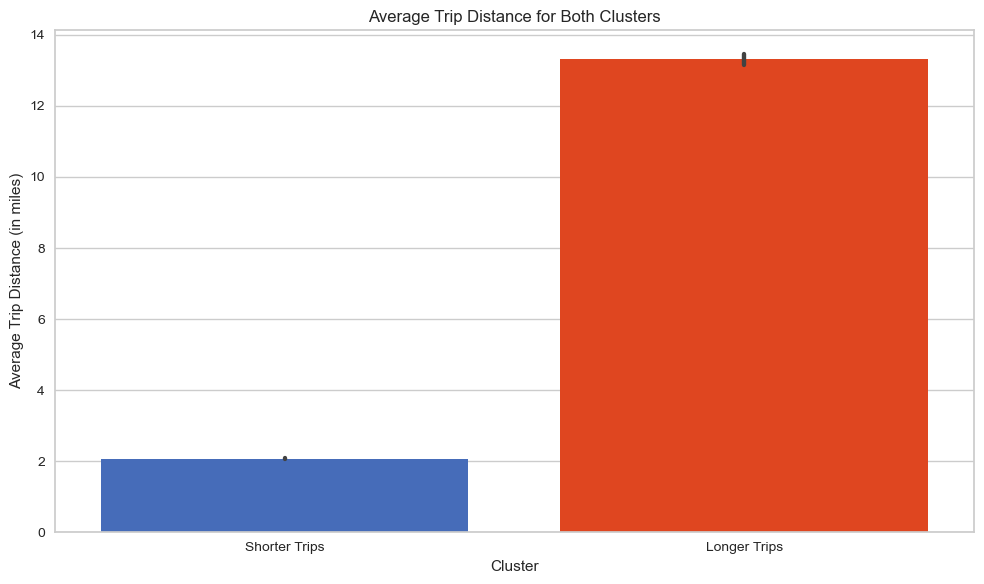

In [61]:
# Plotting average trip distance for both clusters

plt.figure(figsize=(10, 6))

# Create a bar plot
sns.barplot(x='Cluster', y='trip_distance', data=df, palette=custom_palette)

plt.title('Average Trip Distance for Both Clusters')
plt.ylabel('Average Trip Distance (in miles)')
plt.xlabel('Cluster')
plt.tight_layout()
plt.show()

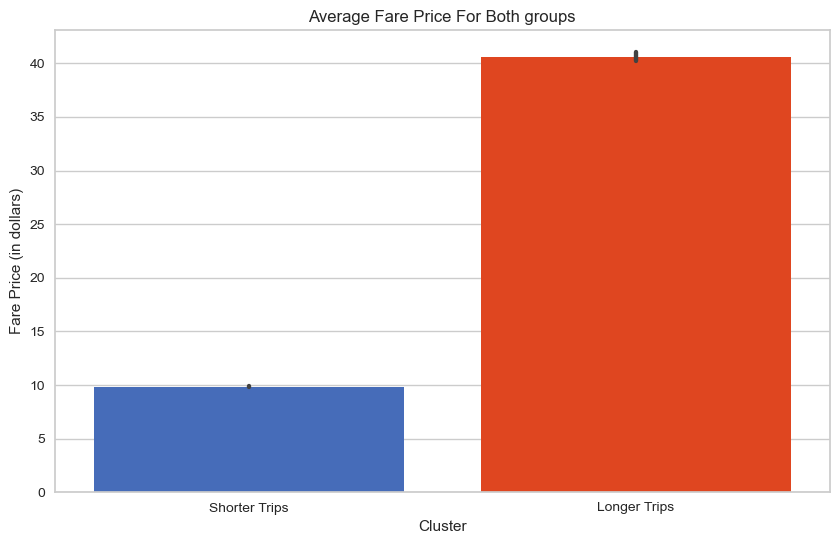

In [62]:
# Plotting the average fare price for the clusters
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='fare_amount', data=df, palette=custom_palette)
plt.title('Average Fare Price For Both groups')
plt.ylabel('Fare Price (in dollars)')
plt.show()

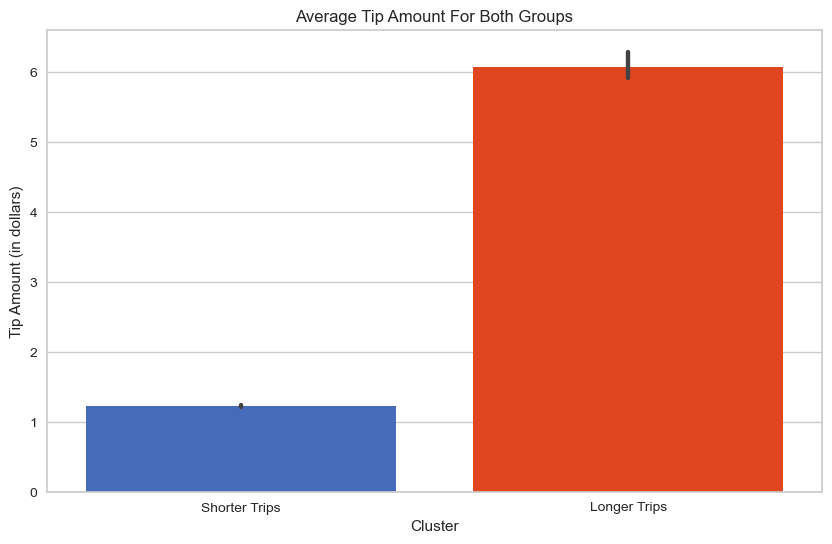

In [63]:
# Plotting the average tip amount for the clusters
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='tip_amount', data=df, palette = custom_palette)
plt.title('Average Tip Amount For Both Groups')
plt.ylabel('Tip Amount (in dollars)')
plt.show()

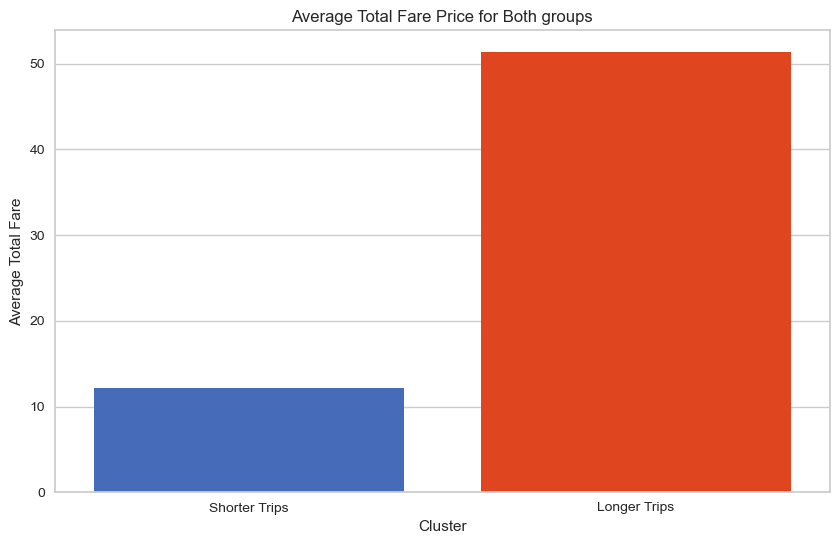

In [64]:
# Calculate the average total_amount for each cluster
avg_total_fare = df.groupby('Cluster')['total_amount'].mean().reset_index()
avg_total_fare = avg_total_fare.sort_values('Cluster', ascending=False)


# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='total_amount', data=avg_total_fare, palette=custom_palette)
plt.title('Average Total Fare Price for Both groups')
plt.ylabel('Average Total Fare')
plt.show()

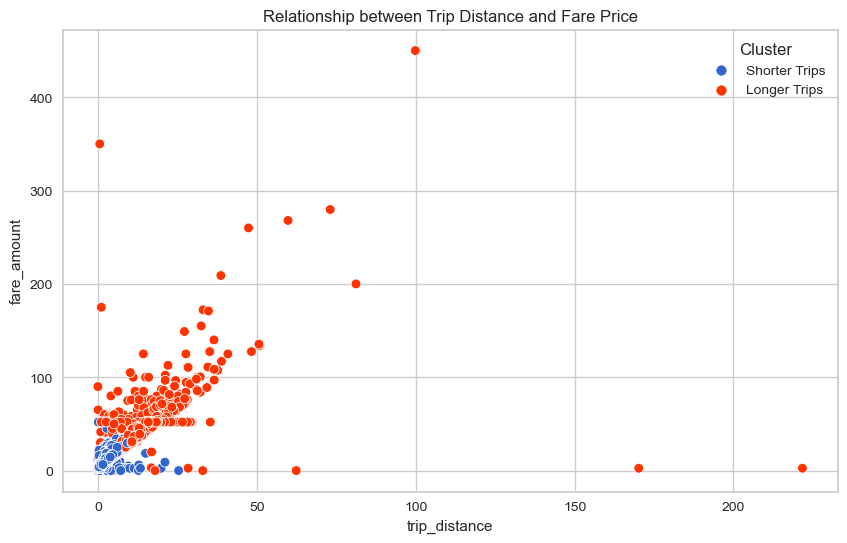

In [65]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='fare_amount', hue='Cluster', data=df, palette=custom_palette)
plt.title('Relationship between Trip Distance and Fare Price')
plt.show()

In [66]:
# Investigating potential geographical patterns based on pickup and dropoff points

import folium

# Sample 500 data points from each cluster for visibility
samples = df.groupby('Cluster').apply(lambda x: x.sample(100))

# Create a base map, New York City
m = folium.Map(location=[40.730610, -73.935242], zoom_start=12)  # Centered around NYC

# Define the colors for the clusters
colors = {"Shorter Trips": 'blue', "Longer Trips": 'red'}

# Loop through the sampled data points to draw lines and round dots
for index, row in samples.iterrows():
    pickup_location = [row['pickup_latitude'], row['pickup_longitude']]
    dropoff_location = [row['dropoff_latitude'], row['dropoff_longitude']]
    
    # Add line between pickup and dropoff
    folium.PolyLine([pickup_location, dropoff_location], color=colors[row['Cluster']], weight=1, opacity=0.5).add_to(m)
    
    # Add dots at pickup and dropoff points
    folium.CircleMarker(pickup_location, color=colors[row['Cluster']], fill=True, fill_color=colors[row['Cluster']], radius=3).add_to(m)
    folium.CircleMarker(dropoff_location, color=colors[row['Cluster']], fill=True, fill_color=colors[row['Cluster']], radius=3).add_to(m)

m.save('nyc_taxi_clusters_map.html')

In [67]:
# Adding a legend to the map for clarity

def add_legend(map_object, colors):
    legend_html = """
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css">
    <div style="position: fixed; bottom: 50px; left: 50px; width: 150px; height: 90px; 
                border:2px solid grey; z-index:9999; font-size:14px; background-color: #ffffff;"> <!-- Added background-color here -->
    &nbsp; <b>Clusters:</b><br>
    &nbsp; Shorter Trips: <i class="fa fa-circle fa-1x" style="color:{}"></i><br>
    &nbsp; Longer Trips: <i class="fa fa-circle fa-1x" style="color:{}"></i>
    </div>
    """.format(colors["Shorter Trips"], colors["Longer Trips"])
    map_object.get_root().html.add_child(folium.Element(legend_html))

add_legend(m, colors)
m.save("nyc_taxi_clusters_map_legend.html")

In [68]:
# Converting relevant columns to datetime

df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Creating a column for what hour in the day pickup happens

df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

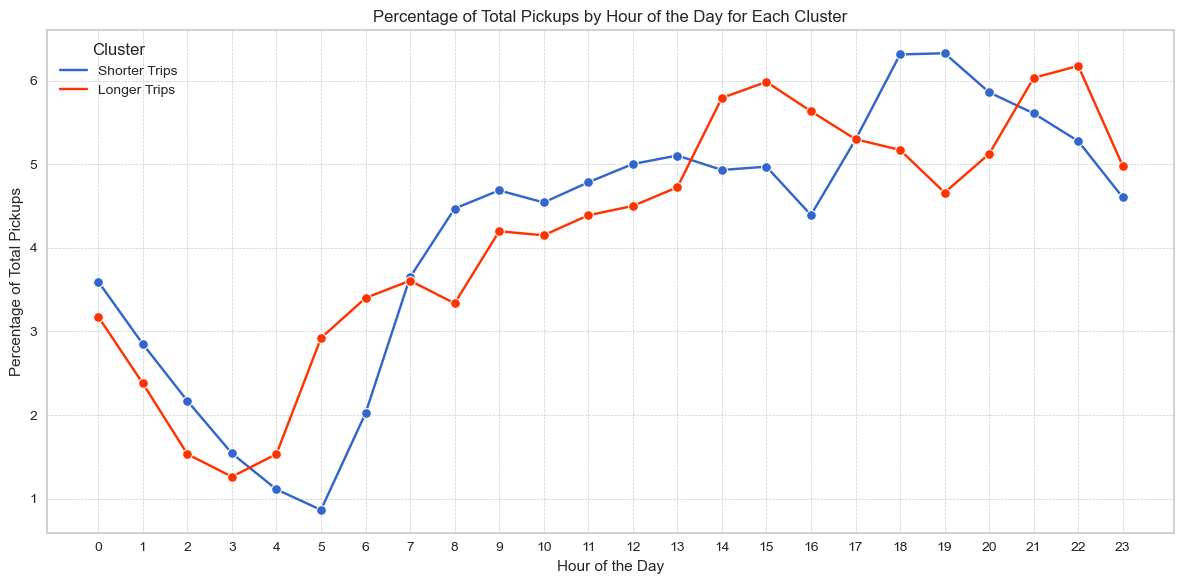

In [69]:
# Visualizing activity per hour for both clusters. X-axis = hour of day, Y-axis = percentage of pickups

# Group by both pickup_hour and Cluster, then compute the count for each group.
hourly_cluster_counts = df.groupby(['pickup_hour', 'Cluster']).size().reset_index(name='count')
hourly_cluster_counts = hourly_cluster_counts.sort_values('Cluster', ascending=False)


# Computing the total pickups for each cluster
total_pickups_shorter = hourly_cluster_counts[hourly_cluster_counts['Cluster'] == 'Shorter Trips']['count'].sum()
total_pickups_longer = hourly_cluster_counts[hourly_cluster_counts['Cluster'] == 'Longer Trips']['count'].sum()

# Calculating the percentages
hourly_cluster_counts.loc[hourly_cluster_counts['Cluster'] == 'Shorter Trips', 'percentage'] = (hourly_cluster_counts['count'] / total_pickups_shorter) * 100
hourly_cluster_counts.loc[hourly_cluster_counts['Cluster'] == 'Longer Trips', 'percentage'] = (hourly_cluster_counts['count'] / total_pickups_longer) * 100

plt.figure(figsize=(12, 6))

# Plotting both clusters with a lineplot
sns.lineplot(x='pickup_hour', y='percentage', hue='Cluster', data=hourly_cluster_counts, marker="o", palette = custom_palette)
plt.title('Percentage of Total Pickups by Hour of the Day for Each Cluster')
plt.ylabel('Percentage of Total Pickups')
plt.xlabel('Hour of the Day')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.legend(title='Cluster')
plt.show()

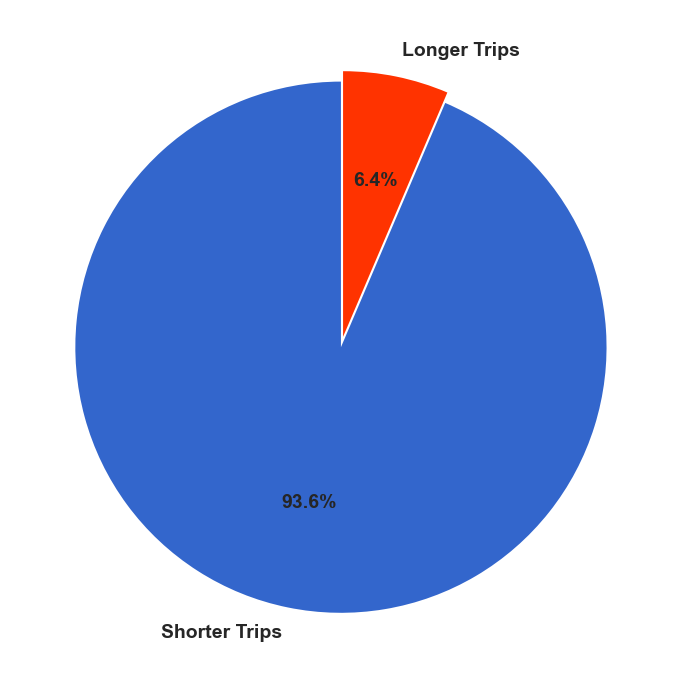

In [70]:
# Calculating the distribution of datapoints across the clusters 

cluster_counts = df['Cluster'].value_counts()

# Create a pie chart
plt.figure(figsize=(7, 7))
explode = (0.02, 0.02)  # this is used to offset each slice a bit to put some space between them

# Plot the pie chart
plt.pie(cluster_counts, 
        labels=cluster_counts.index, 
        colors=custom_palette, 
        autopct='%1.1f%%', 
        startangle=90, 
        explode=explode,
        textprops={'fontsize': 14, 'fontweight': 'bold'})  # Adjust font properties

# Set title with increased font size
plt.tight_layout()
plt.show()